In [1]:
# imports: 
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
torch.manual_seed(0);

In [2]:
train_data = pd.read_csv('energy_train.csv')
test_data = pd.read_csv('energy_test.csv')

In [3]:
x_train = torch.tensor(train_data[['F11','F12', 'F13','F21','F22','F23','F31','F32','F33']].values).float()
y_train = torch.tensor(train_data[['W']].values).float()
x_test = torch.tensor(test_data[['F11','F12', 'F13','F21','F22','F23','F31','F32','F33']].values).float()
y_test = torch.tensor(test_data[['W']].values).float()

In [4]:
# make a square 3x3 matrix from the x_train and x_test
x_train = x_train.view(-1, 3, 3)
x_test = x_test.view(-1, 3, 3)

# for each datapoint on x_train, return the determinant of the matrix
det_train = torch.det(x_train)
det_test = torch.det(x_test)

# make det_train into a a tensor with 600 rows and 1 column
det_train = det_train.view(-1, 1)
det_test = det_test.view(-1, 1)

# transpose each element in x_train
x_train_t = x_train.transpose(1, 2)
x_test_t = x_test.transpose(1, 2)

# multiply each element in x_train_t by x_train
mult_train = torch.bmm(x_train_t, x_train)
mult_test = torch.bmm(x_test_t, x_test)

# get the trace of each element in mult_train
trace_train = torch.diagonal(mult_train, dim1=1, dim2=2).sum(1)
trace_test = torch.diagonal(mult_test, dim1=1, dim2=2).sum(1)

# make trace_train into a tensor with 600 rows and 1 column
trace_train = trace_train.view(-1, 1)
trace_test = trace_test.view(-1, 1)

# concatenate det_train and trace_train
x_train = torch.cat((det_train, trace_train), 1)
x_test = torch.cat((det_test, trace_test), 1)

In [5]:
# Create a forward NN model

# Recall: NN is repeated linear and nonlinear (e.g., ReLU) transformations
# Use 4 hidden layers, each of size 16, and ReLU() activation.
# The input is design parameters with dim = 4
# The output is stiffness with dim = 9 

fwd_nn = torch.nn.Sequential(
    torch.nn.Linear(2,6),
    torch.nn.ReLU(),
    torch.nn.Linear(6,12),
    torch.nn.ReLU(),
    torch.nn.Linear(12,20),
    torch.nn.ELU(),
    torch.nn.Linear(20,15),
    torch.nn.Sigmoid(),
    torch.nn.Linear(15,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,5),
    torch.nn.ReLU(),
    torch.nn.Linear(5,1)
)

#----------------------------------------------
print('Forward neural network:\n\n',fwd_nn)

Forward neural network:

 Sequential(
  (0): Linear(in_features=2, out_features=6, bias=True)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=12, bias=True)
  (3): ReLU()
  (4): Linear(in_features=12, out_features=20, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=20, out_features=15, bias=True)
  (7): Sigmoid()
  (8): Linear(in_features=15, out_features=10, bias=True)
  (9): ReLU()
  (10): Linear(in_features=10, out_features=5, bias=True)
  (11): ReLU()
  (12): Linear(in_features=5, out_features=1, bias=True)
)


In [6]:
# Define an empty list to store loss history
train_loss_history = []
test_loss_history = []

# Learning rate
lr = 0.015

# Optimizer: use Adam
optimizer = torch.optim.Adam(fwd_nn.parameters(), lr = lr)

# Loss function: use the MEAN SQUARED ERROR (MSE) as loss
loss_function = torch.nn.MSELoss()

# number of steps, the proper term is 'EPOCH'
num_epochs = 1000

# begin iterating over epochs
for epoch in range(num_epochs):
    
    # Make your predictions, USE TRAINING DATA ONLY!!
    y_train_pred = fwd_nn(x_train)
    
    # Compute the loss. 
    train_loss = loss_function(y_train_pred, y_train)
    
    
    # store the loss in a list
    train_loss_history.append(train_loss.detach().item())
    
    
    # Call .backward() on loss to compute gradient (d_loss/d_a)
    train_loss.backward()
            
    # Update the model paramaeters 
    # No need for torch.no_grad() anymore with in-built optimizers
    optimizer.step()
    
    # remove any pre-exisitng gradients stored
    optimizer.zero_grad()
    
    
    # We also track the loss on test data but don't use that information for training (just for monitoring purpose)
    with torch.no_grad(): #torch.no_grad() is back because we don't train on test data and so don't need gradients
        
        # Make your predictions
        y_test_pred = fwd_nn(x_test)
        
        # Compute the loss. 
        test_loss = loss_function(y_test_pred, y_test)
        
        
        # store the loss in a list
        test_loss_history.append(test_loss.detach().item())

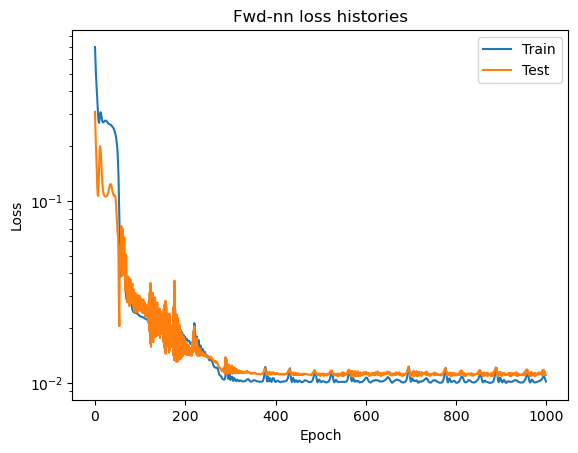

In [7]:
# Plot loss history
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.yscale('log')
plt.legend(['Train','Test']);
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.title('Fwd-nn loss histories');

In [8]:
def calculate_R2(true, pred):
    # Note: both true and pred should be numpy 1D-array, NOT torch tensors
    true_mean = true.mean()
    ss_tot = ((true-true_mean)**2).sum()
    ss_res = ((true-pred)**2).sum()
    return 1. - (ss_res/ss_tot)

def plotR2_strainenergy(true, pred):
    num_of_figs = true.shape[1]
    fig = plt.figure(figsize=(15,15))
    def helper(ax,index):
        R2 = calculate_R2(true[:,index].squeeze().numpy(), pred[:,index].squeeze().detach().numpy())
        R2 = np.round(R2,2)
        ax.scatter(true[:,index], pred[:,index].detach())
        ax.plot([0,true[:,index].max()],[0,true[:,index].max()],c='red')
        ax.set_title('W: {},  R2={}'.format(index,R2))
        ax.set_xlabel('True'); ax.set_ylabel('Predicted')
    for i in range(num_of_figs):
        ax = fig.add_subplot(3, 3, i+1)
        helper(ax,i)
    fig.tight_layout()

def plotR2_design(true, pred):
    num_of_figs = true.shape[1]
    fig = plt.figure(figsize=(15,15))
    labels = ['rho','theta-1','theta-2','theta-3']
    def helper(ax,index):
        R2 = calculate_R2(true[:,index].squeeze().numpy(), pred[:,index].squeeze().detach().numpy())
        R2 = np.round(R2,2)
        ax.scatter(true[:,index], pred[:,index].detach(),c='green')
        ax.plot([0,true[:,index].max()],[0,true[:,index].max()],c='red')
        ax.set_title('{},  R2={}'.format(labels[index],R2))
        ax.set_xlabel('True'); ax.set_ylabel('Predicted')
    for i in range(num_of_figs):
        ax = fig.add_subplot(2, 2, i+1)
        helper(ax,i)
    fig.tight_layout()

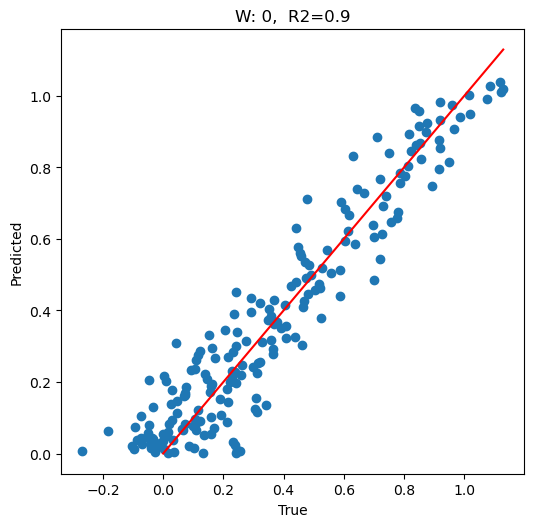

In [9]:
# Make prediction on test set
with torch.no_grad():
    y_tset_pred = fwd_nn(x_test)

# Visualize accuracy
plotR2_strainenergy(y_test, y_test_pred)